# 독립성

In [27]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

import torch
from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer

ckpt_path = '/home/jgryu/Weight_compression/llm-awq/model_cache/models--meta-llama--Meta-Llama-3-8B/snapshots/8cde5ca8380496c9a6cc7ef3a8b46a0372a1d920'
net = AutoModelForCausalLM.from_pretrained(ckpt_path, local_files_only=True)

# mean = np.load(f'/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama--Meta-Llama-3-8B/mlp/d16/mlp_d16_train_mean.npy')
# std = np.load(f'/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama--Meta-Llama-3-8B/mlp/d16/mlp_d16_train_std.npy')
# mean = torch.from_numpy(mean)
# std = torch.from_numpy(std)

state_dict = net.state_dict()

for k, v in state_dict.items():
    print(k, v.shape)


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


model.embed_tokens.weight torch.Size([128256, 4096])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.0.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.up_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.down_proj.weight torch.Size([4096, 14336])
model.layers.0.input_layernorm.weight torch.Size([4096])
model.layers.0.post_attention_layernorm.weight torch.Size([4096])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.1.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.1.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.1.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.1.mlp.up_proj.weight torch.Size([14336, 4096])
model.

1. Distance Correlation

In [ ]:
import dcor
import numpy as np
import json
# 샘플 데이터 생성
plot_data_dcor = {}
dims = [1024, 256, 128, 32, 8, 4, 2, 512, 64, 16]
# dim = 1024
for dim in dims:
    for k, v in state_dict.items():
        if 'embed' in k or 'layernorm' in k: continue
        if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            print(k)
            plot_data_dcor[k] = {}
            for transpose in [False, True]:
                np.random.seed(1)
                print(f'Transpose : {transpose}')
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                num_samples = 4096
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v.reshape(-1, dim)[indices]
                # print(W.shape)

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]
                # print(X.shape, Y.shape)

                dc = dcor.distance_correlation(X, Y)
                # print(f"Distance Correlation: {dc}")
                # plot_data[f'{transpose}'].append(dc)
                plot_data_dcor[k][f'{transpose}'] = dc
                print(dc)
                
                # 독립 여부 판단
                # if dc < 1e-3:  # Threshold는 상황에 따라 조정 가능
                #     print("Variables are likely independent.")
                # else:
                #     print("Variables are dependent.")
    output_filename = f"/home/jgryu/Weight_compression/test_normality/dependency/distance_cor_dim_{dim}.json"
    with open(output_filename, 'w') as json_file:
        json.dump(plot_data_dcor, json_file, indent=4)

In [ ]:
import matplotlib.pyplot as plt

# 카테고리와 값을 추출
categories = []
values = []
colors = []  # 색상 저장
for k, v in plot_data_dcor.items():
    for transpose, dc_value in v.items():
        categories.append(f"{k}_{transpose}")
        values.append(dc_value)
        colors.append('skyblue' if transpose == 'False' else 'orange')  # False는 skyblue, True는 orange

# 막대그래프 생성
plt.figure(figsize=(12, 6))
plt.bar(categories, values, color=colors, edgecolor='black')

# y = 1e-3 직선 추가
plt.axhline(y=1e-3, color='red', linestyle='--', linewidth=1, label='y = 1e-3')

# 그래프 레이블 추가
plt.title('Distance Correlation by Layer and Transpose', fontsize=16)
plt.xlabel('Layer and Transpose', fontsize=12)
plt.ylabel('Distance Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=3)  # 폰트 크기 8로 조정

# # 각 막대 위에 값 표시
# for i, value in enumerate(values):
#     plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

# 범례 추가
plt.legend(['y = 1e-3', 'False (skyblue)', 'True (orange)'], loc='upper right')

# 레이아웃 최적화 및 그래프 출력
plt.tight_layout()
plt.show()


In [ ]:
import dcor
import numpy as np

# 샘플 데이터 생성
plot_data = {}
dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]

for k, v in state_dict.items():
    if 'embed' in k and 'layernorm' in k: continue
    for transpose in [False, True]:
        np.random.seed(1)
        print(f'Transpose : {transpose}')
        plot_data[f'{transpose}'] = []
        for dim in dims:
            # print(f'#### chunk size : {dim} ####')
            if transpose:
                v = v.T
            num_samples = 4096
            indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
            W = v.reshape(-1, dim)[indices]
            # print(W.shape)

            d = W.shape[-1] // 2
            tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
            
            X = tensor_split[0]  # 첫 번째 (-1, 64)
            Y = tensor_split[1]  # 두 번째 (-1, 64)
            
            indices = torch.randperm(X.shape[0])
            X = X[indices]
            Y = Y[indices]
            # print(X.shape, Y.shape)

            dc = dcor.distance_correlation(X, Y)
            # print(f"Distance Correlation: {dc}")
            plot_data[f'{transpose}'].append(dc)
            # 독립 여부 판단
            # if dc < 1e-3:  # Threshold는 상황에 따라 조정 가능
            #     print("Variables are likely independent.")
            # else:
            #     print("Variables are dependent.")
                
    import matplotlib.pyplot as plt
    dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
    plt.figure(figsize=(6.5, 5))
    for l, v in plot_data.items():
        print(v)
        plt.plot(dims, v, marker='o', markersize = 3, linestyle='-', label=l)
        
        
    plt.title(f'{k}, Distance Correlation')
    plt.xlabel('size')
    plt.ylabel('dc')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')

    plt.tight_layout()
    plt.show()

## 2. HSIC (Hilbert-Schmidt Independence Criterion)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
import json
# HSIC 계산 함수
def hsic(X, Y, sigma=1.0):
    K = rbf_kernel(X, X, gamma=1 / (2 * sigma**2))  # X의 RBF 커널
    L = rbf_kernel(Y, Y, gamma=1 / (2 * sigma**2))  # Y의 RBF 커널
    n = K.shape[0]
    H = np.eye(n) - (1/n) * np.ones((n, n))
    
    HSIC_value = np.trace(K @ H @ L @ H) / (n - 1)**2
    return HSIC_value

# # 독립 여부 판단
# if hsic_value < 1e-3:  # Threshold 설정
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")

plot_data_hsic = {}
dims = [1024, 256, 128, 32, 8, 4, 2, 512, 64, 16]
# dim = 1024
for dim in dims:
    for k, v in state_dict.items():
        if 'embed' in k or 'layernorm' in k: continue
        if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            print(k)
            plot_data_hsic[k] = {}
            for transpose in [False, True]:
                np.random.seed(1)
                print(f'Transpose : {transpose}')
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                num_samples = 4096
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v.reshape(-1, dim)[indices]
                # print(W.shape)

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]
                # print(X.shape, Y.shape)

                hsic_value = hsic(X, Y, sigma=1.0)
                print(f"HSIC Value: {hsic_value}")
                plot_data_hsic[k][f'{transpose}'] = hsic_value

    output_filename = f"/home/jgryu/Weight_compression/test_normality/dependency/hisc_dim_{dim}.json"
    with open(output_filename, 'w') as json_file:
        json.dump(plot_data_hsic, json_file, indent=4)

### permutation

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
import json
# HSIC 계산 함수
def hsic(X, Y, sigma=1.0):
    K = rbf_kernel(X, X, gamma=1 / (2 * sigma**2))  # X의 RBF 커널
    L = rbf_kernel(Y, Y, gamma=1 / (2 * sigma**2))  # Y의 RBF 커널
    n = K.shape[0]
    H = np.eye(n) - (1/n) * np.ones((n, n))
    
    HSIC_value = np.trace(K @ H @ L @ H) / (n - 1)**2
    return HSIC_value

def permutation_test_hsic(X, Y, sigma=1.0, num_permutations=1000):
    """
    Permutation Test를 이용하여 HSIC 기반 독립성 검정 수행.
    
    Parameters:
        X: numpy.ndarray, shape (n_samples, n_features)
            첫 번째 변수 데이터.
        Y: numpy.ndarray, shape (n_samples, n_features)
            두 번째 변수 데이터.
        sigma: float, optional
            RBF 커널의 sigma 값 (default: 1.0).
        num_permutations: int, optional
            permutation 반복 횟수 (default: 1000).

    Returns:
        real_hsic: float
            실제 데이터의 HSIC 값.
        p_value: float
            Permutation Test로 계산한 p-value.
    """
    # 실제 데이터의 HSIC 값 계산
    real_hsic = hsic(X, Y, sigma=sigma)

    # Permutation을 통한 HSIC 값 계산
    permuted_hsic_values = []
    for _ in range(num_permutations):
        Y_permuted = np.random.permutation(Y)  # Y를 무작위로 섞음
        permuted_hsic = hsic(X, Y_permuted, sigma=sigma)
        permuted_hsic_values.append(permuted_hsic)

    # p-value 계산
    permuted_hsic_values = np.array(permuted_hsic_values)
    p_value = (np.sum(permuted_hsic_values >= real_hsic) + 1) / (num_permutations + 1)

    return real_hsic, p_value

plot_data_perm_hsic = {}
dims = [256, 128, 32, 8, 4, 2, 512, 64, 16]
# dim = 1024
for dim in dims:
    for k, v in state_dict.items():
        if 'embed' in k or 'layernorm' in k: continue
        if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            print(k)
            plot_data_perm_hsic[k] = {}
            for transpose in [False, True]:
                np.random.seed(1)
                print(f'Transpose : {transpose}')
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                num_samples = 1024
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v.reshape(-1, dim)[indices]
                # print(W.shape)

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]
                # print(X.shape, Y.shape)

                real_hsic, p_value = permutation_test_hsic(X, Y, sigma=1.0, num_permutations=1000)
                print(f"HSIC (Real Data): {real_hsic}")
                print(f"p-value: {p_value}")

                plot_data_perm_hsic[k][f'{transpose}'] = p_value

    output_filename = f"/home/jgryu/Weight_compression/test_normality/dependency/perm_hisc_dim_{dim}.json"
    with open(output_filename, 'w') as json_file:
        json.dump(plot_data_perm_hsic, json_file, indent=4)

model.layers.0.self_attn.q_proj.weight
Transpose : False
HSIC (Real Data): 1.6398268319927842e-05
p-value: 0.009900990099009901
Transpose : True
HSIC (Real Data): 8.903682967377665e-06
p-value: 0.009900990099009901
model.layers.0.self_attn.k_proj.weight
Transpose : False
HSIC (Real Data): 2.1290772197202822e-05
p-value: 0.009900990099009901
Transpose : True
HSIC (Real Data): 3.0419278623617662e-05
p-value: 0.009900990099009901
model.layers.0.self_attn.v_proj.weight
Transpose : False
HSIC (Real Data): 8.183678595356543e-09
p-value: 0.009900990099009901
Transpose : True
HSIC (Real Data): 4.3260137128578204e-08
p-value: 0.009900990099009901
model.layers.0.self_attn.o_proj.weight
Transpose : False
HSIC (Real Data): 1.5977053789370359e-07
p-value: 0.009900990099009901
Transpose : True
HSIC (Real Data): 4.912755424016203e-08
p-value: 0.009900990099009901
model.layers.0.mlp.gate_proj.weight
Transpose : False
HSIC (Real Data): 3.4263172453544986e-07
p-value: 0.009900990099009901
Transpose : Tr

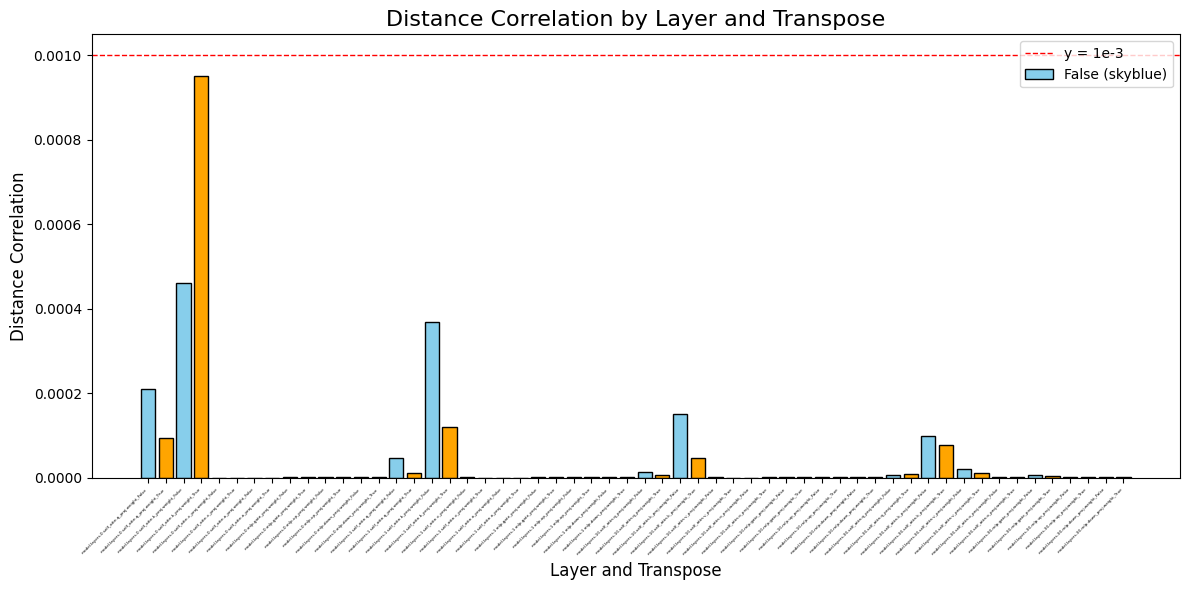

In [ ]:
import matplotlib.pyplot as plt

# 카테고리와 값을 추출

with open('/home/jgryu/Weight_compression/test_normality/dependency/hisc_dim_1024.json', 'r', encoding='utf-8') as file:
    plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환

categories = []
values = []
colors = []  # 색상 저장
for k, v in plot_data.items():
    if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
        for transpose, dc_value in v.items():
            categories.append(f"{k}_{transpose}")
            values.append(dc_value)
            colors.append('skyblue' if transpose == 'False' else 'orange')  # False는 skyblue, True는 orange

# 막대그래프 생성
plt.figure(figsize=(12, 6))
plt.bar(categories, values, color=colors, edgecolor='black')

# y = 1e-3 직선 추가
plt.axhline(y=1e-3, color='red', linestyle='--', linewidth=1, label='y = 1e-3')

# 그래프 레이블 추가
plt.title('HISC by Layer and chunk direction', fontsize=16)
plt.xlabel('Layer and Transpose', fontsize=12)
plt.ylabel('HISC value', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=3)  # 폰트 크기 8로 조정

# # 각 막대 위에 값 표시
# for i, value in enumerate(values):
#     plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

# 범례 추가
plt.legend(['y = 1e-3', 'False (skyblue)', 'True (orange)'], loc='upper right')

# 레이아웃 최적화 및 그래프 출력
plt.tight_layout()
plt.show()


# # 독립 여부 판단
# if hsic_value < 1e-3:  # Threshold 설정
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

# HSIC 계산 함수
def hsic(X, Y, sigma=1.0):
    K = rbf_kernel(X, X, gamma=1 / (2 * sigma**2))  # X의 RBF 커널
    L = rbf_kernel(Y, Y, gamma=1 / (2 * sigma**2))  # Y의 RBF 커널
    n = K.shape[0]
    H = np.eye(n) - (1 / n) * np.ones((n, n))

    HSIC_value = np.trace(K @ H @ L @ H) / (n - 1)**2
    return HSIC_value

# Permutation Test 함수
def permutation_test_hsic(X, Y, sigma=1.0, num_permutations=1000):
    """
    Permutation Test를 이용하여 HSIC 기반 독립성 검정 수행.
    
    Parameters:
        X: numpy.ndarray, shape (n_samples, n_features)
            첫 번째 변수 데이터.
        Y: numpy.ndarray, shape (n_samples, n_features)
            두 번째 변수 데이터.
        sigma: float, optional
            RBF 커널의 sigma 값 (default: 1.0).
        num_permutations: int, optional
            permutation 반복 횟수 (default: 1000).

    Returns:
        real_hsic: float
            실제 데이터의 HSIC 값.
        p_value: float
            Permutation Test로 계산한 p-value.
    """
    # 실제 데이터의 HSIC 값 계산
    real_hsic = hsic(X, Y, sigma=sigma)

    # Permutation을 통한 HSIC 값 계산
    permuted_hsic_values = []
    for _ in range(num_permutations):
        Y_permuted = np.random.permutation(Y)  # Y를 무작위로 섞음
        permuted_hsic = hsic(X, Y_permuted, sigma=sigma)
        permuted_hsic_values.append(permuted_hsic)

    # p-value 계산
    permuted_hsic_values = np.array(permuted_hsic_values)
    p_value = (np.sum(permuted_hsic_values >= real_hsic) + 1) / (num_permutations + 1)

    return real_hsic, p_value

# 예제 데이터
np.random.seed(42)
X = np.random.randn(100, 1)  # 100개의 샘플, 1차원
Y = X + 0.5 * np.random.randn(100, 1)  # X에 약간의 노이즈 추가

# Permutation Test 수행
real_hsic, p_value = permutation_test_hsic(X, Y, sigma=1.0, num_permutations=1000)

print(f"HSIC (Real Data): {real_hsic}")
print(f"p-value: {p_value}")


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
# HSIC 계산 함수
def hsic(X, Y, sigma=1.0):
    K = rbf_kernel(X, X, gamma=1 / (2 * sigma**2))  # X의 RBF 커널
    L = rbf_kernel(Y, Y, gamma=1 / (2 * sigma**2))  # Y의 RBF 커널
    n = K.shape[0]
    H = np.eye(n) - (1/n) * np.ones((n, n))
    
    # HSIC 계산
    HSIC_value = np.trace(K @ H @ L @ H) / (n - 1)**2
    return HSIC_value

# 샘플 데이터 생성
# np.random.seed(0)
# X = np.random.rand(1000, 50)  # 50차원 데이터
# Y = np.random.rand(1000, 50)  # 독립적인 50차원 데이터

# # HSIC 계산
# X = X[:10000]
# Y = Y[:10000]
# hsic_value = hsic(X, Y, sigma=1.0)
# print(f"HSIC Value: {hsic_value:.4f}")

# # 독립 여부 판단
# if hsic_value < 1e-3:  # Threshold 설정
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")
import dcor
import numpy as np

# 샘플 데이터 생성
plot_data = {}
dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]

for k, v in state_dict.items():
    if 'layers.0' in k or 'layers.1' in k or 'layers.10' in k or 'layers.30' in k:
        if 'layernorm' in k: continue
        print(k, v.shape)
        for transpose in [False, True]:
            np.random.seed(1)
            print(f'Transpose : {transpose}')
            plot_data[f'{transpose}'] = []
            for dim in dims:
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                v = v.reshape(-1, dim)
                num_samples = 2000
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v[indices]

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]
                # print(X.shape, Y.shape)

                hsic_value = hsic(X, Y, sigma=1.0)
                # print(f"HSIC Value: {hsic_value:.4f}")
                plot_data[f'{transpose}'].append(hsic_value)

                    
        import matplotlib.pyplot as plt
        dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
        plt.figure(figsize=(6.5, 5))
        for l, v in plot_data.items():
            print(v)
            plt.plot(dims, v, marker='o', markersize = 3, linestyle='-', label=l)
            
            
        plt.title(f'{k},  HSIC')
        plt.xlabel('size')
        plt.ylabel('hsic_value')
        plt.legend()
        plt.grid(True)
        plt.xscale('log')

        plt.tight_layout()
        plt.show()

## 3. Permutation Test + Distance Correlation

In [29]:
import numpy as np
import dcor
from sklearn.metrics.pairwise import rbf_kernel
import json
# HSIC 계산 함수
def hsic(X, Y, sigma=1.0):
    K = rbf_kernel(X, X, gamma=1 / (2 * sigma**2))  # X의 RBF 커널
    L = rbf_kernel(Y, Y, gamma=1 / (2 * sigma**2))  # Y의 RBF 커널
    n = K.shape[0]
    H = np.eye(n) - (1/n) * np.ones((n, n))
    
    HSIC_value = np.trace(K @ H @ L @ H) / (n - 1)**2
    return HSIC_value

# # 독립 여부 판단
# if p_value > 0.05:
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")


# plot_data_perm_dc = {}
dims = [1024, 256, 128, 32, 8, 4, 2, 512, 64, 16]
# dim = 1024
for dim in dims:
    print('dim: ', dim)
    for k, v in state_dict.items():
        if 'embed' in k or 'layernorm' in k: continue
        if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
        # if 'layers.30.' in k:
            print(k)
            plot_data_perm_dc[k] = {}
            for transpose in [False, True]:
                np.random.seed(1)
                print(f'Transpose : {transpose}')
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                num_samples = 2000
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v.reshape(-1, dim)[indices]
                # print(W.shape)

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]

                dc_real = dcor.distance_correlation(X, Y)
                perm_dc = []
                num_permutations = 1000
                for _ in range(num_permutations):
                    Y_perm = np.random.permutation(Y)  # Y를 무작위로 섞음
                    dc_perm = dcor.distance_correlation(X, Y_perm)
                    perm_dc.append(dc_perm)

                # p-value 계산
                p_value = (np.sum(np.array(perm_dc) >= dc_real) + 1) / (num_permutations + 1)
                plot_data_perm_dc[k][f'{transpose}'] = p_value
                print(p_value)
    output_filename = f"/home/jgryu/Weight_compression/test_normality/dependency/perm_dc_dim_{dim}_num_permutations_{num_permutations}.json"
    with open(output_filename, 'w') as json_file:
        json.dump(plot_data_perm_dc, json_file, indent=4)

dim:  1024
model.layers.0.self_attn.q_proj.weight
Transpose : False
0.000999000999000999
Transpose : True
0.000999000999000999
model.layers.0.self_attn.k_proj.weight
Transpose : False
0.000999000999000999
Transpose : True
0.000999000999000999
model.layers.0.self_attn.v_proj.weight
Transpose : False
0.000999000999000999
Transpose : True
0.000999000999000999
model.layers.0.self_attn.o_proj.weight
Transpose : False
0.000999000999000999
Transpose : True
0.000999000999000999
model.layers.0.mlp.gate_proj.weight
Transpose : False


KeyboardInterrupt: 

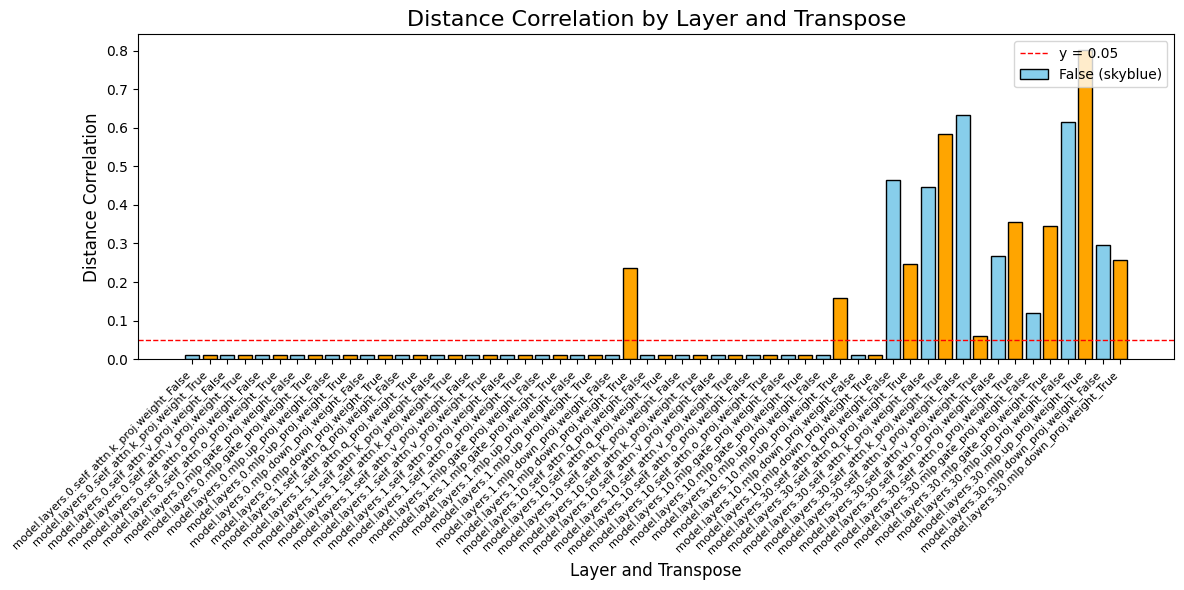

In [ ]:
import matplotlib.pyplot as plt

# 카테고리와 값을 추출

with open('/home/jgryu/Weight_compression/test_normality/dependency/perm_dc_dim_2.json', 'r', encoding='utf-8') as file:
    plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환

categories = []
values = []
colors = []  # 색상 저장
for k, v in plot_data.items():
    if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
        for transpose, dc_value in v.items():
            categories.append(f"{k}_{transpose}")
            values.append(dc_value)
            colors.append('skyblue' if transpose == 'False' else 'orange')  # False는 skyblue, True는 orange

# 막대그래프 생성
plt.figure(figsize=(12, 6))
plt.bar(categories, values, color=colors, edgecolor='black')

# y = 1e-3 직선 추가
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='y = 1e-3')

# 그래프 레이블 추가
plt.title('Distance Correlation by Layer and Transpose', fontsize=16)
plt.xlabel('Layer and Transpose', fontsize=12)
plt.ylabel('Distance Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)  # 폰트 크기 8로 조정

# # 각 막대 위에 값 표시
# for i, value in enumerate(values):
#     plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

# 범례 추가
plt.legend(['y = 0.05', 'False (skyblue)', 'True (orange)'], loc='upper right')

# 레이아웃 최적화 및 그래프 출력
plt.tight_layout()
plt.show()

# # 독립 여부 판단
# if p_value > 0.05:
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")

In [ ]:
import dcor
import numpy as np

# 샘플 데이터 생성
# np.random.seed(0)
# X = np.random.rand(1000, 50)  # 50차원 데이터
# Y = np.random.rand(1000, 50)  # 독립적인 50차원 데이터

# # 실제 Distance Correlation 계산
# dc_real = dcor.distance_correlation(X, Y)

# # Permutation Test
# perm_dc = []
# num_permutations = 100
# for _ in range(num_permutations):
#     Y_perm = np.random.permutation(Y)  # Y를 무작위로 섞음
#     dc_perm = dcor.distance_correlation(X, Y_perm)
#     perm_dc.append(dc_perm)

# # p-value 계산
# p_value = (np.sum(np.array(perm_dc) >= dc_real) + 1) / (num_permutations + 1)

# print(f"Real Distance Correlation: {dc_real:.4f}")
# print(f"p-value: {p_value:.4f}")

# # 독립 여부 판단
# if p_value > 0.05:
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")

plot_data = {}
dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]

for k, v in state_dict.items():
    if 'layers.0' in k or 'layers.1' in k or 'layers.10' in k or 'layers.30' in k:
        if 'layernorm' in k: continue
        for transpose in [False, True]:
            print(k, v.shape)
            np.random.seed(1)
            # print(f'Transpose : {transpose}')
            plot_data[f'{transpose}'] = []
            for dim in dims:
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                v = v.reshape(-1, dim)
                num_samples = 2000
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v[indices]

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]
                # print(X.shape, Y.shape)

                dc_real = dcor.distance_correlation(X, Y)
                perm_dc = []
                num_permutations = 10
                for _ in range(num_permutations):
                    Y_perm = np.random.permutation(Y)  # Y를 무작위로 섞음
                    dc_perm = dcor.distance_correlation(X, Y_perm)
                    perm_dc.append(dc_perm)

                # p-value 계산
                p_value = (np.sum(np.array(perm_dc) >= dc_real) + 1) / (num_permutations + 1)
                plot_data[f'{transpose}'].append(p_value)

                # print(f"Real Distance Correlation: {dc_real}")
                # print(f"p-value: {p_value}")
                
                # if p_value > 0.05:
                #     print("Variables are likely independent.")
                # else:
                #     print("Variables are dependent.")

                    
        import matplotlib.pyplot as plt
        dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
        plt.figure(figsize=(6.5, 5))
        for l, v in plot_data.items():
            print(v)
            plt.plot(dims, v, marker='o', markersize = 3, linestyle='-', label=l)
            
            
        plt.title(f'{k},  Permutation Test + Distance Correlation')
        plt.xlabel('size')
        plt.ylabel('p_value')
        plt.legend()
        plt.grid(True)
        plt.xscale('log')

        plt.tight_layout()
        plt.show()



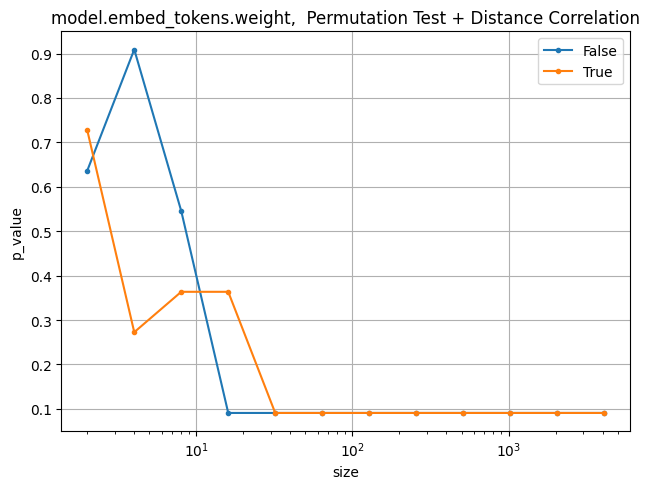